In [1]:
from src.utils.preprocess_utils import midi_to_one_hot
from src.utils.ml_utils import create_dataloaders, train_model, test_model, plot_metrics
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import os

In [2]:
# Define dataset
class MidiDataset(Dataset):
    def __init__(self, data_dir, sequence_length=150):
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith('.mid') or f.endswith('.midi')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(self.data_dir, file_name)
        
        try:
            data = midi_to_one_hot(file_path)
            
            if data.shape[0] < self.sequence_length:
                raise ValueError(f"File {file_name} is too short for sequence length {self.sequence_length}")
            
            # Pick a random starting index and crop the data to sequence_length
            start_idx = np.random.randint(0, data.shape[0] - self.sequence_length + 1)
            cropped_data = data[start_idx:start_idx + self.sequence_length]

            x = cropped_data[:-1] # Input
            y = cropped_data[1:] # "Label"

            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            # If the file is invalid or too short, retry with another random file
            new_idx = np.random.randint(0, len(self.file_names))
            return self.__getitem__(new_idx)

dataset = MidiDataset(data_dir='data/midis', sequence_length=150)

In [3]:
# Get dataloaders with specified params from ml_utils
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(dataset=dataset, batch_size=32, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True)

In [4]:
# Define model architecture
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, input_size]
        out, _ = self.lstm(x)  # out: [batch_size, sequence_length, hidden_size]
        out = self.fc(out)
        return out

input_size = 85  # One-hot size = number of notes
hidden_size = 128  # Size of the hidden state
output_size = 85  # Predict the next note (same size as input)

model = LSTMModel(input_size, hidden_size, output_size)

Error processing Breslaur, Emil, Die leichtesten Klavierstücke, Op.46, fgIRzt9vfHI.mid: File Breslaur, Emil, Die leichtesten Klavierstücke, Op.46, fgIRzt9vfHI.mid is too short for sequence length 150
Error processing Stahl, William C., Golden Bell Waltz, gmrKI53VUVQ.mid: File Stahl, William C., Golden Bell Waltz, gmrKI53VUVQ.mid is too short for sequence length 150
Error processing Spindler, Fritz, Schneeglöckchen, Op.19, qNZDvjBqKCs.mid: File Spindler, Fritz, Schneeglöckchen, Op.19, qNZDvjBqKCs.mid is too short for sequence length 150
Error processing Czerny, Carl, 110 Progressive Excercises, Op.453, RfCjHjj6Zxw.mid: File Czerny, Carl, 110 Progressive Excercises, Op.453, RfCjHjj6Zxw.mid is too short for sequence length 150
Error processing Carr, Benjamin, The Analytical Instructor for the Piano Forte, bbu3W8AB33Q.mid: File Carr, Benjamin, The Analytical Instructor for the Piano Forte, bbu3W8AB33Q.mid is too short for sequence length 150
Error processing Satie, Erik, Allegro, 3yGYXvq-s

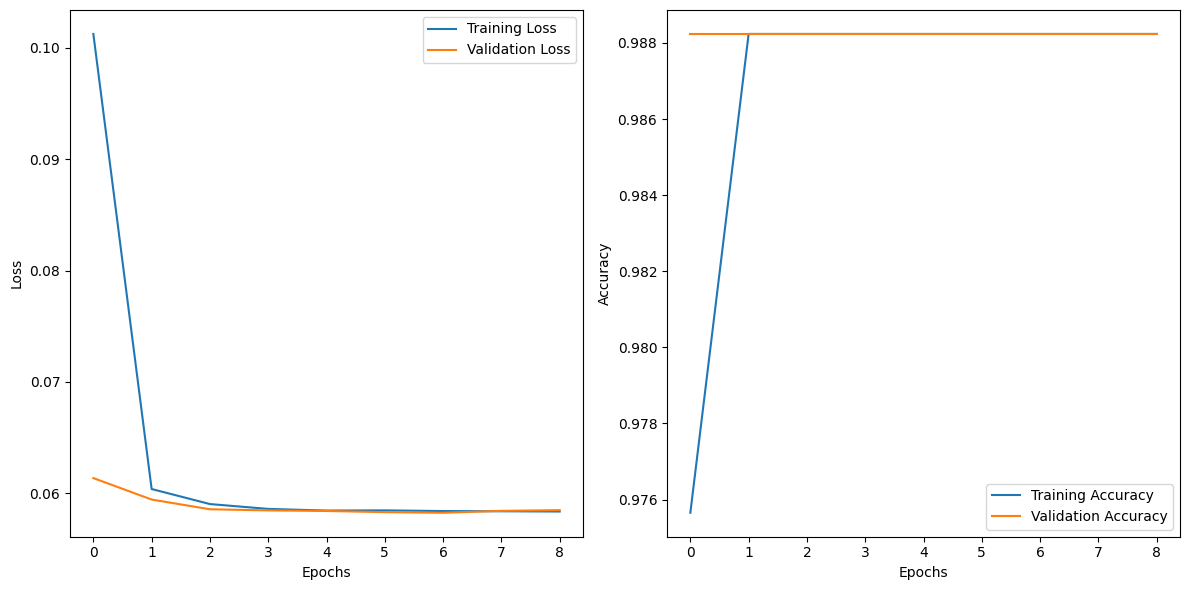

In [5]:
# Train model from ml_utils
best_model, history = train_model(
    model=model,
    dataloaders={"train": dataloader_train, "val": dataloader_val},
    task_type="multi-label",
    n_epochs=10,
    device="cuda"
)
(train_losses, val_losses, train_accuracy, val_accuracy) = history
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

In [8]:
# Test model from ml_utils
test_model(best_model, dataloader_test, nn.BCEWithLogitsLoss(), task_type="multi-label", device="cuda")

Error processing Spindler, Fritz, Hexenfahrt, Op.11, Gi_Zoy36LzQ.mid: File Spindler, Fritz, Hexenfahrt, Op.11, Gi_Zoy36LzQ.mid is too short for sequence length 150
Error processing Hamilton, Gregory, Pastel for Organ, SnCWnkzEurY.mid: File Hamilton, Gregory, Pastel for Organ, SnCWnkzEurY.mid is too short for sequence length 150
Error processing Purcell, Henry, Air in D Minor, ZT 675, MKQbysfs8HI.mid: File Purcell, Henry, Air in D Minor, ZT 675, MKQbysfs8HI.mid is too short for sequence length 150
Error processing Pozzoli, Ettore, Sanctus in C major, TVchWOEKp9g.mid: File Pozzoli, Ettore, Sanctus in C major, TVchWOEKp9g.mid is too short for sequence length 150
Error processing Methfessel, Albert Gottlieb, Im süßen Traum bei stiller Nacht, cVlmwki6GRc.mid: File Methfessel, Albert Gottlieb, Im süßen Traum bei stiller Nacht, cVlmwki6GRc.mid is too short for sequence length 150
Test metrics - Loss: 0.0585, Accuracy: 0.9882


(np.float64(0.05849808564080911), np.float64(0.9882353532548044))

In [9]:
# Save model
from datetime import datetime
torch.save(best_model, 'weights/model_1/' + datetime.today().strftime('%Y-%m-%d_%H-%M-%S'))